You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

## 1. Set up

### 1 - Drive

1 - Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

KeyboardInterrupt: ignored

2 - Move to the data folder

In [ ]:
cd "gdrive/MyDrive/Projects/1 - Numericals/Predict Future Sales/2 - Production/data"

### 2. Libraries

In [ ]:
# Load data
import pandas as pd
import numpy as np
import io
import os
import glob

# Meta
import time

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sb

# Analysis
from scipy.stats import zscore

## 3. Data

1 - List file names

In [ ]:
ls

competitive-data-science-predict-future-sales.zip  sales_train.csv
item_categories.csv                                sample_submission.csv
items.csv                                          shops.csv
kaggle.json                                        test.csv


In [ ]:
# Load only 'sales_train.csv' for now
df = pd.read_csv('sales_train.csv')

### 4. Classes

1 - Define the class

A - Data Assessment of one class

In [ ]:
# Class that helps the assessment of each table individually
class DataAssessment:

  def __init__(self, df):
    self.df = df


  # Get the basic file information
  def files_basic_info(self):
    '''
    Function - Get the very basic details about the data files
    Input - None
    Action - Find the number of csv files, file size,
            number of rows and number of columns
    Dependencies - 
      import glob
      import os
    '''
    begin = time.time()
    
    # Get all the files in the folder
    files = os.listdir()
    file_list = glob.glob('*.csv')

    # Find the number of files in the folder
    print('The number of files in the directory is:',len([name for name in os.listdir('.') if os.path.isfile(name)]))
    print('\n')
    print('The file names are:')
    print(files)
    print('\n')

    # Get the details of the csv files
    print('The csv files details are:')
    print('\n')
    for i in file_list:
      print('File:',i)
      file_size = os.path.getsize(i)
      converted_size = self.formatFileSize(file_size, 'B', 'MB', precision=0)
      df = pd.read_csv(i,error_bad_lines=False)
      df_shape = df.shape
      n_rows = df_shape[0]
      n_columns = df_shape[1]
      file_size = self.formatFileSize(file_size, 'B', 'MB', precision=2)
      head = df.head()
      print('File size:',file_size,'MB')
      print('Number of data points:',n_rows)
      print('Number of features:',n_columns)
      print('\n')
    end = time.time()
    self.find_time_taken(begin, end)

  
  # Code attribution : https://www.codegrepper.com/code-examples/python/convert+bytes+to+mb+python
  def convertFloatToDecimal(self, f=0.0, precision=2):
      '''
      Function: Convert a float to string of decimal.
      precision: by default 2.
      If no arg provided, return "0.00".
      '''
      return ("%." + str(precision) + "f") % f


  # Code attribution : https://www.codegrepper.com/code-examples/python/convert+bytes+to+mb+python
  def formatFileSize(self, size, sizeIn, sizeOut, precision=0):
    '''
    Function: Convert file size to a string representing its value in B, KB, MB and GB.
    The convention is based on sizeIn as original unit and sizeOut
    as final unit. 
    '''
    assert sizeIn.upper() in {"B", "KB", "MB", "GB"}, "sizeIn type error"
    assert sizeOut.upper() in {"B", "KB", "MB", "GB"}, "sizeOut type error"
    if sizeIn == "B":
        if sizeOut == "KB":
            return self.convertFloatToDecimal((size/1024.0), precision)
        elif sizeOut == "MB":
            return self.convertFloatToDecimal((size/1024.0**2), precision)
        elif sizeOut == "GB":
            return self.convertFloatToDecimal((size/1024.0**3), precision)
    elif sizeIn == "KB":
        if sizeOut == "B":
            return self.convertFloatToDecimal((size*1024.0), precision)
        elif sizeOut == "MB":
            return self.convertFloatToDecimal((size/1024.0), precision)
        elif sizeOut == "GB":
            return self.convertFloatToDecimal((size/1024.0**2), precision)
    elif sizeIn == "MB":
        if sizeOut == "B":
            return self.convertFloatToDecimal((size*1024.0**2), precision)
        elif sizeOut == "KB":
            return self.convertFloatToDecimal((size*1024.0), precision)
        elif sizeOut == "GB":
            return self.convertFloatToDecimal((size/1024.0), precision)
    elif sizeIn == "GB":
        if sizeOut == "B":
            return self.convertFloatToDecimal((size*1024.0**3), precision)
        elif sizeOut == "KB":
            return self.convertFloatToDecimal((size*1024.0**2), precision)
        elif sizeOut == "MB":
            return self.convertFloatToDecimal((size*1024.0), precision)


    # Show the first 10 rows of the dataframe
  def print_head(self, df):
    '''
    Function: Print the first 10 rows of the dataframe 
    Input: A dataframe
    Output: The first 10 rows of the dataframe
    '''
    return df.head(n=10)
  
  # Show a single datapoint vertically
  def print_vertically(self, df):
    '''
    Function: Print the first data point vertically
    Input: A dataframe
    Output: The first data point vertically
    '''
    return df.iloc[0]

  # Find duplicates
  def find_duplicates(self, df):
    '''
    Function - Find and display duplicate columns and rows of the dataframe
    Input - Dataframe
    Output - Display duplicate columns and rows of the dataframe
    '''
    begin = time.time()

    # Find duplicate rows
    row_duplicates = df[df.duplicated()]
    
    # Find duplicate columns
    duplicate_columns = set()
    other_columns = set()
    
    for x in range(df.shape[1]):
      col = df.iloc[:, x]
      for y in range(x + 1, df.shape[1]):
        otherCol = df.iloc[:, y]
        
        if col.equals(otherCol):
          duplicate_columns.add(df.columns.values[y])
          other_columns.add(df.columns.values[x])
    
    dup_columns = (list(duplicate_columns))
    dup_other_columns = (list(other_columns))

    
    columns = 2
    rows = len(dup_columns)
    column_duplicates = []
    column_duplicates = [[0 for i in range(columns)] for j in range(rows)]
    
    for i in range(len(column_duplicates)):
      val_one = dup_columns[i]
      val_two = dup_other_columns[i]
      column_duplicates[0][i] = val_one
      column_duplicates[i][1] = val_two
    print('\nRow duplicates:')
    print(row_duplicates)
    print('\n')
    print('\nColumn duplicates:')
    print(column_duplicates)

    end = time.time()
    time_taken = end - begin


  # Check the data types of the dataframe
  def check_feature_types(self, df):
    '''
    Function: Get basic information on the dataframe 
    Input: Dataframe
    Output: Some basic information on the dataframe 
    '''
    begin = time.time()

    # Get the information from the dataframe

    # Get the shape of the dataframe
    data_shape = df.shape
    # Get the data types
    data_types = df.dtypes
    # Get the number of rows and columns
    n_rows = data_shape[0]
    n_columns = data_shape[1]
    # Find the missing values
    null_values = df.isnull().sum()
    # Find numeric columns and categorical columns
    numeric_columns = df.select_dtypes([np.number]).columns.tolist()
    columns = list(df)
    categorical_columns = []
    for i in columns:
      if i not in numeric_columns:
        categorical_columns.append(i)
      else:
        None
    
    print('\nCategorical columns:',len(categorical_columns))
    print(categorical_columns)
    print('\nNumeric columns:',len(numeric_columns))
    print(numeric_columns)
    print('\n')
    print('The column type information:')
    df.info()
    end = time.time()
    
    # Display the time taken to run this procedure
    end = time.time()
    self.find_time_taken(begin, end)


  # Function to calculate the time taken to run the function that calls it
  def find_time_taken(self, begin, end):
    '''
    Function: Calculate the time taken to run this procedure
    Input: Beginning time, ending time
    Action: Calculate the time taken for a procedure to be run in minutes or seconds
    '''
    time_taken = end - begin

    if time_taken >= 60:
      time_taken = round(time_taken/60,2)
      print("Time taken to run this procedure:",time_taken,"minutes")
    else:
      time_taken = round(time_taken,2)
    print('\n')
    print("Time taken to run this procedure:",time_taken,"seconds")

  
  # Missing values analysis
  def missing_data_basic_analysis(self, df):
    '''
    Function: Provide analysis on the missing values in the dataframe
    Input: Dataframe
    Output: Row-wise and column-wise analysis of NaN values in the dataframe
    '''

    begin = time.time()

    data_shape = df.shape
    n_rows = data_shape[0]
    n_columns = data_shape[1]
    null_values = df.isnull().sum()
    columns_nans = df.isnull().sum()[df.isnull().sum() > 0]
    n_columns_nans = len(columns_nans)
    percent_nan_columns = round((columns_nans/n_rows)*100,2).sort_values()
    percent = percent_nan_columns
    drop_columns = percent.where(percent > 30)
    drop_columns = drop_columns.dropna()
    n_drop_columns = len(drop_columns)

    all_nan_rows = df[(df.T.isnull()).all()]

    nan_count_column = []
    for index, row in df.iterrows():
      nan_count = df.loc[[index]].isna().sum().sum()
      nan_count_column.append(round((nan_count/n_columns)*100,2))
    df['NaN %'] = nan_count_column
    df.sort_values(by=['NaN %'])
    
    print('Column Analysis:')
    print('\nColumns with null values:')
    print('There are',n_columns_nans,'columns with null values which is',round((n_columns_nans/n_columns)*100,0),'percent of the features')
    print('\nColumns with NaNs:')
    print(percent_nan_columns)
    print('\nColumns with NaNs greater than 30%:')
    print(drop_columns)
    print('\nNumber of columns to be dropped:')
    print(n_drop_columns,'needs to be dropped, that is,',round((n_drop_columns/n_columns)*100,0),'% of total features')
    print('\nDescriptive analysis of columns with missing values')
    print(percent_nan_columns.describe())

    print('\nRow Analysis:')
    print('\nThe number of rows with all NaN values are:',all_nan_rows.shape[0])
    df.drop('NaN %', inplace=True, axis=1)
    end = time.time()

    # Display the time taken to run this procedure
    self.find_time_taken(begin, end)

  
  def missing_data_basic_analysis_v2(self, df):
    '''
    Function: Provide analysis on the missing values in the dataframe if the dataframe is large 1M rows or above
    Input: Dataframe
    Output: Row-wise and column-wise analysis of NaN values in the dataframe
    '''
    begin = time.time()
    data_shape = df.shape
    n_rows = data_shape[0]
    n_columns = data_shape[1]
    null_values = df.isnull().sum()
    columns_nans = df.isnull().sum()[df.isnull().sum() > 0]
    n_columns_nans = len(columns_nans)
    percent_nan_columns = round((columns_nans/n_rows)*100,2).sort_values()
    percent = percent_nan_columns
    drop_columns = percent.where(percent > 30)
    drop_columns = drop_columns.dropna()
    n_drop_columns = len(drop_columns)

    all_nan_rows = df[(df.T.isnull()).all()]

    print('Column Analysis:')
    print('\nColumns with null values:')
    print('There are',n_columns_nans,'columns with null values which is',round((n_columns_nans/n_columns)*100,0),'percent of the features')
    print('\nColumns with NaNs:')
    print(percent_nan_columns)
    print('\nColumns with NaNs greater than 30%:')
    print(drop_columns)
    print('\nNumber of columns to be dropped:')
    print(n_drop_columns,'needs to be dropped, that is,',round((n_drop_columns/n_columns)*100,0),'% of total features')
    print('\nDescriptive analysis of columns with missing values')
    print(percent_nan_columns.describe())
    print('\nMissing Values in Rows')
    print(all_nan_rows)
    end = time.time()

    # Display the time taken to run this procedure
    self.find_time_taken(begin, end)

    

  # Analyze the zero values in the dataframe
  def zero_value_analysis(self, df):
    '''
    Function: Get row-wise and column-wise analysis of 0 values in the dataframe
    Input: Dataframe
    Output: Row-wise and column-wise analysis of 0 values in the dataframe
    '''

    begin = time.time()

    nulls = df.eq(0).sum() 
    column_1 = df.columns
    
    column_2 = nulls.tolist()
    
    dataframe_shape = df.shape
    dataframe_rows = dataframe_shape[0]
    dataframe_columns = dataframe_shape[1]
    column_3 = []
    for i in column_2:
      column_3.append((round(i/dataframe_rows,2))*100)

    # Get a table with the column name, number of null values and percentage of null values
    final_data = {'Column Name':column_1, 'Zero Values':column_2, '% of Zeroes':column_3}
    null_values_table = pd.DataFrame(final_data,columns = ['Column Name','Zero Values','% of Zeroes'])
    null_values_table.sort_values(by=['% of Zeroes'], inplace=True, ascending=False)
    #selection = df.loc[df['mylist']==0]
    null_values_table = null_values_table.loc[null_values_table['Zero Values'] > 0]

    print("Columns:")
    print('\n')
    print('Number of columns with 0 values:',null_values_table.shape[0])
    print(null_values_table)

    print('\n')
    print('Rows:')
    print('\n')
    
    zero_rows = df[(df.T == 0).all()]
    n_zero_rows = zero_rows.shape[0]
    print('The number of rows with only zero values is:',n_zero_rows)
    print('The percentage of rows with only zero values is:',round((n_zero_rows/dataframe_rows)*100,2))
    end = time.time()

    # Display the time taken to run this procedure
    self.find_time_taken(begin, end)
  

  # Cardinality of features
  def display_cardinality(self, df):
    '''
    Function: Show cardinality of features in the datframe
    Input: A dataframe
    Output: Column names and their cardinality
    '''
    begin = time.time()
    unique_values = df.nunique()
    print(unique_values)
    end = time.time()

    # Display the time taken to run this procedure
    self.find_time_taken(begin, end)
  

  # Show all unique values in a single column
  def unique_values(self, df, column_name):
    '''
    Function: Show unique values of the column
    Input: The dataframe and column name in string format
    Output: Unique values of a column
    '''

    begin = time.time()
    unique_values = df[column_name].unique()
    print(unique_values)
    end = time.time()

    # Display the time taken to run this procedure
    self.find_time_taken(begin, end)


  # Show the categorical and numeric features
  def feature_types(self, df):
    '''
    Function: Find the number and names of categorical and numeric features
    Input: Dataframe
    Output: The number and names of categorical and numeric features
    '''
    begin = time.time()

    # Get the information from the dataframe
    numeric_columns = df.select_dtypes([np.number]).columns.tolist()
    columns = list(df)
    categorical_columns = []
    for i in columns:
      if i not in numeric_columns:
        categorical_columns.append(i)
      else:
        None
    
    # Print the information
    print('\nCategorical columns:',len(categorical_columns))
    print(categorical_columns)
    print('\nNumeric columns:',len(numeric_columns))
    print(numeric_columns)
    end = time.time()

    # Display the time taken to run this procedure
    self.find_time_taken(begin, end)
  

  # Check spaces in column headers
  def check_spaces(self, df):
    '''
    Functions: Check if column headers have spaces and return names of those that do
    Input: Dataframe
    Output: Names of column headers with spaces
    '''
    begin = time.time()

    list_1 = df.columns
    list_2 = [c.replace(' ', '_') for c in list_1]
    col_names = set(list_1)-set(list_2)
    return list(col_names)
    end = time.time()

    # Display the time taken to run this procedure
    self.find_time_taken(begin, end)


  # Numeric feature descriptive statistics
  def numeric_feature_details(self, df):
    '''
    Function: Display descriptive statistics of all numeric features in the dataframe
    Input: Dataframe
    Output: Descriptive statistics of all numeric features in the dataframe
    '''
    begin = time.time()

    # Get the information from the dataframe

    numeric_columns = df.select_dtypes([np.number]).columns.tolist()
    print('Number of numeric columns:', len(numeric_columns))
    print(numeric_columns)
    print('\n')

    for i in numeric_columns:
      print('Column Name:',i)
      print(df[i].describe())
      print('\n')
      print('median:',df[i].median())
      print('mode:',df[i].mode())
      print('\n')
    end = time.time()

    # Display the time taken to run this procedure
    self.find_time_taken(begin, end)


  def numeric_details_list(self, df, column_list):
    '''
    Function: Find the number and names of categorical and numeric features
    Input: Dataframe
    Output: The number and names of categorical and numeric features
    '''
    begin = time.time()

    # Get the information from the dataframe

    numeric_columns = column_list
    print('Number of numeric columns:', len(numeric_columns))
    print(numeric_columns)
    print('\n')

    for i in numeric_columns:
      print('Column Name:',i)
      print(df[i].describe())
      print('\n')
      print('median:',df[i].median())
      print('mode:',df[i].mode())
      print('\n')
    end = time.time()
    
    # Display the time taken to run this procedure
    self.find_time_taken(begin, end)

    #Time taken to run this procedure
    self.find_time_taken(begin, end)

  
  # Certain columns can have a standardized length - check values of such columns
  def check_value_length(self, df, column_name):
    '''
    Function: To find the length of a value in a given column
    Input: The dataframe and name of the column as a variable
    Output: The length of a value in a given column
    '''
    begin = time.time()
    df_copy = df.copy(deep=False)
    df_copy['character_length'] = df_copy[column_name].astype(str).map(len)
    print(df_copy['character_length'].unique())
    end = time.time()

    # Display the time taken to run this procedure
    self.find_time_taken(begin, end)
  


  def get_column_lists(self, df):
    '''
    Function: Get the categorical and numerical column names of a dataframe as two lists
    Input: A dataframe
    Output: The categorical and numerical column name lists
    '''
    begin = time.time()

    numeric_columns = df.select_dtypes([np.number]).columns.tolist()
    columns = list(df)
    categorical_columns = []
    for i in columns:
      if i not in numeric_columns:
        categorical_columns.append(i)
      else:
        None
    end = time.time()
    
    # Display the time taken to run this procedure
    self.find_time_taken(begin, end)
    return numeric_columns, categorical_columns
  

  def convert_columns_string(self, df):
    '''
    Function: Convert all columns in the given dataframe to string type
    Input: A dataframe
    Output: The dataframe with all columns in string type
    '''
    begin = time.time()
    df_copy = df.copy(deep=False)
    for i in df_copy:
        df_copy[i] = df_copy[i].astype(str)
    end = time.time()
  
    # Display the time taken to run this procedure
    self.find_time_taken(begin, end)
    return df_copy
  

  def check_column_values(self, df, column_list):
    '''
    Function: Check for data quality in each value of each categorical column
    Input: The dataframe and the list of categorical columns
    Output: Presence of spaces, numeric values, decimals, all alphabets, digits, 
            if the value is in lower, upper and title cases
    Dependency: Use convert_columns_string() to convert all columns to string format. 
                Or use get_column_lists() to get numeric and categorical column name lists
    '''
    begin = time.time()
    try:
            print('\n')
            print('Check if all characters in the string are whitespaces. True if space exists, else False.')
            for i in column_list:
              print('Column name:',i)
              check = df[i].str.isspace()
              print(check.unique())

            print('\n')
            print('Check whether all characters are numeric. True if only numeric, else False.')
            for i in column_list:
              print('Column name:',i)
              check = df[i].str.isnumeric()
              print(check.unique())

            print('\n')
            print('Check whether all characters are only alphabetic. True if there are only alphabets, else False.')
            for i in column_list:
              print('Column name:',i)
              check = df[i].str.isalpha()
              print(check.unique())

            print('\n')
            print('Check whether all characters are only digits. True if there are only digits, else False.')
            for i in column_list:
              print('Column name:',i)
              check = df[i].str.isdigit()
              print(check.unique())

            print('\n')
            print('Check whether all characters are only decimal. True if there are only decimal, else False.')
            for i in column_list:
              print('Column name:',i)
              check = df[i].str.isdecimal()
              print(check.unique())

            print('\n')
            print('Check whether all characters are only lower. True if there are only lower case, else False.')
            for i in column_list:
              print('Column name:',i)
              check = df[i].str.islower()
              print(check.unique())

            print('\n')
            print('Check whether all characters are only upper. True if there are only upper case, else False.')
            for i in column_list:
              print('Column name:',i)
              check = df[i].str.isupper()
              print(check.unique())
            
            print('\n')
            print('Check whether all characters are only upper. True if there are only upper case, else False.')
            for i in column_list:
              print('Column name:',i)
              check = df[i].str.istitle()
              print(check.unique())
          
    except:
      print('\nPlease check the above column type. Only columns of string type are allowed.')
      print('Check if the column is numeric or boolean and remove them from the column_list list.')
    
    end = time.time()

    # Display the time taken to run this procedure
    self.find_time_taken(begin, end)


  def remove_elements_lists(self, main_list, remove_list):
    '''
    Function: Remove a set of elements from a list using another list
    Input: Two lists
    Output: The list where elements in the second lists are removed from the first list
    '''
    begin = time.time()
    final_list = []
    [final_list.append(x) for x in main_list if x not in remove_list]
    end = time.time()
      
    # Display the time taken to run this procedure
    self.find_time_taken(begin, end)
    return final_list
  

  def replace_nans_zero(self, df, column_list):
    '''
    Function: Replace NaNs in the dataframe columns with 0
    Input: Dataframe, list of columns
    Output: Dataframe with values in specified column list 0
    '''
    begin = time.time()
    df_copy = df.copy(deep=False)
    for i in column_list:
      df_copy[i] = df_copy[i].replace(np.nan, 0)
    end = time.time()
      
    # Display the time taken to run this procedure
    self.find_time_taken(begin, end)
    
    return df_copy
  

  def scatter_column_values(self, df, x_value, y_value):
    '''
    Function: Scatter plot between two columns in the same dataframe
    Input: Dataframe, x-value, y-value
    Output: Scatter plot
    Dependency: import matplotlib.pyplot as plt
    '''
    begin = time.time()
    df.plot(x=x_value, y=[y_value], kind='scatter')
    print(x_value,'vs.',y_value)
    print('\n')
    plt.figure(figsize=(3, 4))
    plt.show()

    end = time.time()
      
    # Display the time taken to run this procedure
    self.find_time_taken(begin, end)
  

  def print_outlier_values(self, df, column_name):
    '''
    Function: Find the higher and lower outlier values of a column.
              Get two dataframes with only higher and lower values rows
    Input: Dataframe and a column name
    Outout: Two dataframes with higher and lower outliers respectively
    '''
    begin = time.time()
    quartiles = df[column_name].quantile([0.25,0.5,0.75])
    q1 = quartiles[0.25]
    q3 = quartiles[0.75]
    iqr = q3 - q1
    lower_outlier_filter = q1 - 1.5 * iqr
    higher_outlier_filter = q3 + 1.5 * iqr
    print('Higher outliers:',higher_outlier_filter)
    print('Lower outliers:',lower_outlier_filter)
    end = time.time()
      
    # Display the time taken to run this procedure
    self.find_time_taken(begin, end)


  def get_outlier_dfs(self, df, column_name):
    '''
    Function: Find the higher and lower outlier values of a column.
              Get two dataframes with only higher and lower values rows
    Input: Dataframe and a column name
    Outout: Two dataframes with higher and lower outliers respectively
    '''
    begin = time.time()
    quartiles = df[column_name].quantile([0.25,0.5,0.75])
    q1 = quartiles[0.25]
    q3 = quartiles[0.75]
    iqr = q3 - q1
    lower_outlier_filter = q1 - 1.5 * iqr
    higher_outlier_filter = q3 + 1.5 * iqr
    df_higher_outliers = df.loc[(df[column_name] > higher_outlier_filter)]
    df_lower_outliers = df.loc[(df[column_name] < lower_outlier_filter)]
    end = time.time()
      
    # Display the time taken to run this procedure
    self.find_time_taken(begin, end)
    return df_higher_outliers, df_lower_outliers


  def get_outlier_normal_dist(self, df, column_name):
    '''
    Function: Get higher outlier dataframe based on the given column that is distributed normally
    Input: Dataframe, column name
    Output: Higher outlier dataframe
    Dependency: from scipy.stats import zscore
    '''
    begin = time.time()
    df_copy = df.copy(deep=False)
    new_col = column_name + '_zscore'
    df_copy[new_col] = zscore(df[column_name])
    df_higher_outliers = df_copy.loc[(abs(df_copy[new_col]) > 3)]
    end = time.time()
      
    # Display the time taken to run this procedure
    self.find_time_taken(begin, end)
    return df_higher_outliers

  def get_index_list(self, df, series):
    '''
    Function: Get indices of the dataframe where the series value is True 
    Input: The dataframe, a series
    Output: The dataframe with indeices
    '''
    index_list = series.loc[series == True].index.tolist()
    df_index = df.iloc[index_list]
    return df_index
  

  def scatter_column_values(self, df, x_value, y_value):
    '''
    Function: Scatter plot between two columns in the same dataframe
    Input: Dataframe, x-value, y-value
    Output: Scatter plot
    Dependency: matplotlib.pyplot imported as plt
    '''
    begin = time.time()
    df.plot(x=x_value, y=[y_value], kind='scatter')
    print(x_value,'vs.',y_value)
    print('\n')
    plt.figure(figsize=(3, 4))
    plt.show()

    end = time.time()
      
    # Display the time taken to run this procedure
    self.find_time_taken(begin, end)


    def print_outlier_values(self, df, column_name):
      '''
      Function: Find the higher and lower outlier values of a column.
                Get two dataframes with only higher and lower values rows
      Input: Dataframe and a column name
      Outout: Two dataframes with higher and lower outliers respectively
      '''
      begin = time.time()
      quartiles = twitter_archive[column_name].quantile([0.25,0.5,0.75])
      q1 = quartiles[0.25]
      q3 = quartiles[0.75]
      iqr = q3 - q1
      lower_outlier_filter = q1 - 1.5 * iqr
      higher_outlier_filter = q3 + 1.5 * iqr
      print('Higher outliers:',higher_outlier_filter)
      print('Lower outliers:',lower_outlier_filter)
      end = time.time()
        
      # Display the time taken to run this procedure
      self.find_time_taken(begin, end)


    def get_outlier_dfs(self, df, column_name):
      '''
      Function: Find the higher and lower outlier values of a column.
                Get two dataframes with only higher and lower values rows
      Input: Dataframe and a column name
      Outout: Two dataframes with higher and lower outliers respectively
      '''
      begin = time.time()
      quartiles = df[column_name].quantile([0.25,0.5,0.75])
      q1 = quartiles[0.25]
      q3 = quartiles[0.75]
      iqr = q3 - q1
      lower_outlier_filter = q1 - 1.5 * iqr
      higher_outlier_filter = q3 + 1.5 * iqr
      df_higher_outliers = df.loc[(df[column_name] > higher_outlier_filter)]
      df_lower_outliers = df.loc[(df[column_name] < lower_outlier_filter)]
      end = time.time()
        
      # Display the time taken to run this procedure
      self.find_time_taken(begin, end)
      return df_higher_outliers, df_lower_outliers
  

    def get_outlier_normal_dist(self, df, column_name):
      '''
      Function: Get higher outlier dataframe based on the given column that is distributed normally
      Input: Dataframe, column name
      Output: Higher outlier dataframe
      Dependency: from scipy.stats import zscore
      '''
      begin = time.time()
      df_copy = df.copy(deep=False)
      new_col = column_name + '_zscore'
      df_copy[new_col] = zscore(df[column_name])
      df_higher_outliers = df_copy.loc[(abs(df_copy[new_col]) > 3)]
      end = time.time()
        
      # Display the time taken to run this procedure
      self.find_time_taken(begin, end)
      return df_higher_outliers
    

  def check_decimal_places(self, df, column_list):
    '''
    Function: Check the number of decimal places in a given column
    Input: The dataframe, column_list
    Output: The unique number of decimal places found in the columns
    '''
    begin = time.time()
    for i in column_list:
      places = -np.floor(np.log10(df[i]))
      n_unique_places = places.unique()
      print('Column Name:',i)
      print(n_unique_places)
      print('\n')
    end = time.time()
    
    # Display the time taken to run this procedure
      
    self.find_time_taken(begin, end)


  def barchart(self, df, column_name, chart_type):
    '''
    Function: Create bar chart
    Input: The dataframe and column name
    Output: Bar chart showing the frequency
    Dependency: import seaborn as sb
    '''

    begin = time.time()
    if chart_type == 'abs':
      sb.set_theme(style="whitegrid")
      sb.set_color_codes("pastel")
      #pal = ['black', 'grey', 'grey', 'grey']
      pal = "ch:.25"
      sb.set_style(style='white')
      title_value = column_name + ' absolute frequency'
      ax = sb.countplot(data = df, x = column_name, palette=pal).set(title=title_value)
      #order = titanic['class'].value_counts().index

    else:
      title_value = column_name + ' relative frequency'
      proportions_column = round(df[column_name].value_counts()/len(df),3)
      df_1 = pd.DataFrame({'Unique Values':proportions_column.index, 'Percentage':proportions_column.values})
      ax = df_1.plot.bar(x='Unique Values', y='Percentage', title = title_value, legend=False)
      ax.set_xlabel(column_name)
      ax.set_ylabel("Relative Frequency")
      # Hide grids
      ax.grid(False)
      # Hide axes ticks
      ax.set_xticks([])
      ax.set_yticks([])
      #ax.plot(legend=False)
      print('\n')
      # Show proportions
      print('Proportion Values:')
      print(df_1)
      print('\n')
    end = time.time()
    
    # Display the time taken to run this procedure
      
    self.find_time_taken(begin, end)
  

  def get_column_lists(self, df):
    '''
    Function: Get the categorical and numerical column names of a dataframe as two lists
    Input: A dataframe
    Output: The categorical and numerical column name lists
    '''
    begin = time.time()

    numeric_columns = df.select_dtypes([np.number]).columns.tolist()
    columns = list(df)
    categorical_columns = []
    for i in columns:
      if i not in numeric_columns:
        categorical_columns.append(i)
      else:
        None
    end = time.time()
    
    # Display the time taken to run this procedure
      
    self.find_time_taken(begin, end)
    return numeric_columns, categorical_columns
  

  def unique_values_categorical(self, df, column_list):
    '''
    Function: Find the number of unique values in the column lists
    Input: The dataframe and column list
    Output: Column name and the number of unique values
    '''
    begin = time.time()
    for i in column_list:
      print('Column Name:',i)
      unique = df[i].unique()
      print(len(unique))
    end = time.time()
    
    # Display the time taken to run this procedure
      
    self.find_time_taken(begin, end)


  def bin_num_range_selector(self, df, column_name):
    '''
    Function: Find the minimum and maximum values of the column
    Input: Dataframe, column name
    Output: Maximum and minimum values in the dataframe
    '''
    begin = time.time()
    # Find the maximum value in the column
    maximum = df[column_name].max()
    # Find the minimum value in the column
    minimum = df[column_name].min()
    
    print('Maximum:',maximum)
    print('Minimum:',minimum)

    end = time.time()
    
    # Display the time taken to run this procedure
      
    self.find_time_taken(begin, end)
  

  def bin_num_helper(self, upper, lower):
    '''
    Function: Get bin size suggestions as a list
    Input: Upper and lower values. 
            Upper - Slightly higher than the maximum value of the column (51 if max is 50). Must be a whole number
            Lower - Slightly lower than the minimum value of the column (1 if min is 2). Must be a whole number
    Output: A list of bin size suggestions
    '''
    begin = time.time()
    range = upper - lower
    num_range = np.arange(1,20).tolist()

    # Create a list of all values where range is divisible by numbers from 1 to 20
    divisible_num = []
    for i in num_range:
      if range%i == 0:
        divisible_num.append(i)
    print('Bin size suggestions:',divisible_num)
    print('\nOr any bin size from the range 1 to 20')
    end = time.time()
    
    # Display the time taken to run this procedure
      
    self.find_time_taken(begin, end)


  def make_histogram(self, df, column_name, n_bin):
    '''
    Function: Display histogram
    Input: Dataframe, column name of a numeric column and number of bins
    Output: Histogram
    '''
    begin = time.time()
    n_bin = n_bin
    fig = plt.figure(figsize=(15,4))
    ax = plt.gca()
    counts, _, patches = ax.hist(df[column_name], bins=n_bin)
    for count, patch in zip(counts,patches):
        ax.annotate(str(int(count)), xy=(patch.get_x(), patch.get_height()))
    plt.xlabel(column_name+' bins') 
    plt.ylabel('Frequency') 
    plt.title(column_name)
    plt.show()
    end = time.time()
    
    # Display the time taken to run this procedure
      
    self.find_time_taken(begin, end)

  
  def find_substring_item(self, column_vals_list, substring_list):
    '''
    Function: Find the substring in the unique values of the column
    Input: Column values as a list
    Output: Elements of the list that contain the substring
    '''
    begin = time.time()
    for i in substring_list:
      print('\nItems with the substring:',i)
      #print('\n')
      for j in column_vals_list:
        if(i in j):
          print(j)

    end = time.time()
    
    # Display the time taken to run this procedure
      
    self.find_time_taken(begin, end)


  # Check the frequency of the column
  def frequency_col(self, df, column_name):
    '''
    Function: Create a dataframe with frequency of a column in the given dataframe
    Input: The dataframe, column name
    Output: The dataframe with frequencies of the given column name
    '''
    begin = time.time()
    frequency = df[column_name].value_counts()
    end = time.time()
    
    # Display the time taken to run this procedure
      
    self.find_time_taken(begin, end)
    return frequency
  

  def frequency_table_groupby(self, df, column_name):
    '''
    Function: Group the table frequency with a column
    Input: The dataframe, column name
    Output: The dataframe with frequencies of all the columns grouped by a single column
    '''
    begin = time.time()
    frequency_df = df.groupby(column_name).count()
    end = time.time()
    self.find_time_taken(begin, end)
    return df

  def check_positive(self, df, column_name): 
    '''
    Function: Check if a column has only positive values or not
    Input: The dataframe and column name
    Output: Shows if the data frame has positive or negatie values
    '''
    begin = time.time()

    check = df[column_name] > 0
    print(check.unique())
    
    end = time.time()
    self.find_time_taken(begin, end)



2 - Create an instance of the class

In [ ]:
# Instance of DataAssessment class
instance = DataAssessment(df)

## 2. Asess Data

### 1 - sales_train.csv

1 - Check feature types

In [ ]:
instance.feature_types(df)


Categorical columns: 1
['date']

Numeric columns: 5
['date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day']


Time taken to run this procedure: 0.04 seconds


2 - Get basic information on the dataframe

In [ ]:
instance.check_feature_types(df)


Categorical columns: 1
['date']

Numeric columns: 5
['date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day']


The column type information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


Time taken to run this procedure: 0.18 seconds


3. Check the number of decimal places in float type columns

In [ ]:
column_list = ['item_price', 'item_cnt_day']
instance.check_decimal_places(df, column_list)

Column Name: item_price
[-2. -3. -1. -4. -0. nan  1.  2. -5.]


Column Name: item_cnt_day
[-0. nan -1. -2. -3.]




Time taken to run this procedure: 0.19 seconds


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


4. Find and display duplicate columns and rows of the dataframe

In [ ]:
instance.find_duplicates(df)


Row duplicates:
               date  date_block_num  shop_id  item_id  item_price  \
76962    05.01.2013               0       54    20130       149.0   
1435367  23.02.2014              13       50     3423       999.0   
1496766  23.03.2014              14       21     3423       999.0   
1671873  01.05.2014              16       50     3423       999.0   
1866340  12.07.2014              18       25     3423       999.0   
2198566  31.12.2014              23       42    21619       499.0   

         item_cnt_day  
76962             1.0  
1435367           1.0  
1496766           1.0  
1671873           1.0  
1866340           1.0  
2198566           1.0  



Column duplicates:
[]


5. Provide analysis on the missing values in the dataframe

In [ ]:
instance.missing_data_basic_analysis_v2(df)

Column Analysis:

Columns with null values:
There are 0 columns with null values which is 0.0 percent of the features

Columns with NaNs:
Series([], dtype: float64)

Columns with NaNs greater than 30%:
Series([], dtype: float64)

Number of columns to be dropped:
0 needs to be dropped, that is, 0.0 % of total features

Descriptive analysis of columns with missing values
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
dtype: float64

Missing Values in Rows
Empty DataFrame
Columns: [date, date_block_num, shop_id, item_id, item_price, item_cnt_day]
Index: []
Time taken to run this procedure: 1.17 minutes


Time taken to run this procedure: 1.17 seconds


6. Get row-wise and column-wise analysis of 0 values in the dataframe

In [ ]:
instance.zero_value_analysis(df)

Columns:


Number of columns with 0 values: 3
      Column Name  Zero Values  % of Zeroes
1  date_block_num       115690          4.0
2         shop_id         9857          0.0
3         item_id            1          0.0


Rows:


The number of rows with only zero values is: 0
The percentage of rows with only zero values is: 0.0
Time taken to run this procedure: 1.17 minutes


Time taken to run this procedure: 1.17 seconds


In [ ]:
# Find the row where item_id == 0
rslt_df = df[df['item_id'] == 0]
rslt_df

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1972636,01.09.2014,20,54,0,58.0,1.0


7. Show cardinality of features in the datframe

In [ ]:
instance.display_cardinality(df)

date               1034
date_block_num       34
shop_id              60
item_id           21807
item_price        19993
item_cnt_day        198
dtype: int64


Time taken to run this procedure: 0.27 seconds


8. Frequency unique values of the column - shop_id

In [ ]:
column_name = 'shop_id'

In [ ]:
instance.bin_num_range_selector(df, column_name)

Maximum: 59
Minimum: 0


Time taken to run this procedure: 0.02 seconds


In [ ]:
instance.bin_num_helper(0, 60)

Bin size suggestions: [1, 2, 3, 4, 5, 6, 10, 12, 15]

Or any bin size from the range 1 to 20


Time taken to run this procedure: 0.0 seconds


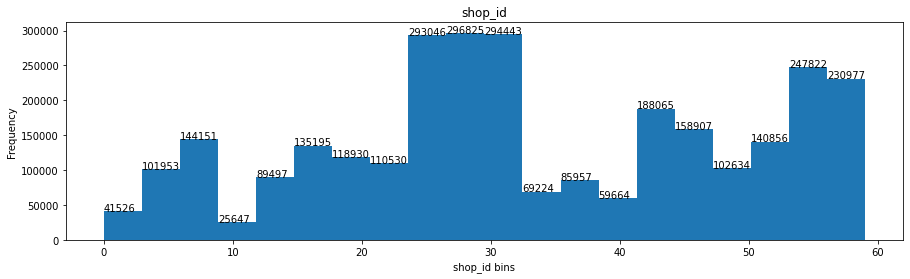



Time taken to run this procedure: 0.3 seconds


In [ ]:
n_bin = 20
instance.make_histogram(df, column_name, n_bin)

9. Frequency unique values of the column - item_id

In [ ]:
column_name = 'item_id'

In [ ]:
instance.bin_num_range_selector(df, column_name)

Maximum: 22169
Minimum: 0


Time taken to run this procedure: 0.01 seconds


In [ ]:
instance.bin_num_helper(0, 22170)

Bin size suggestions: [1, 2, 3, 5, 6, 10, 15]

Or any bin size from the range 1 to 20


Time taken to run this procedure: 0.0 seconds


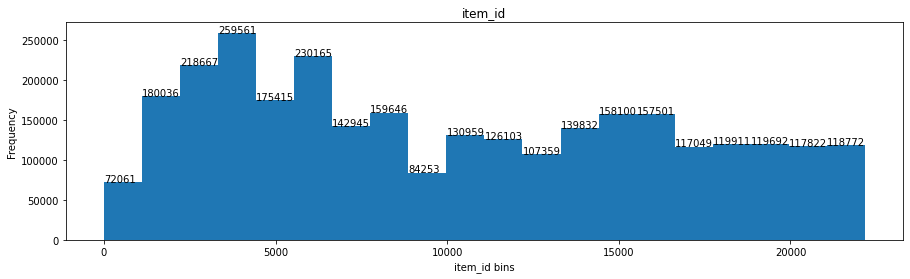



Time taken to run this procedure: 0.27 seconds


In [ ]:
n_bin = 20
instance.make_histogram(df, column_name, n_bin)

10. Frequency unique values of the column - item_cnt_day

In [ ]:
column_name = 'item_cnt_day'

In [ ]:
instance.bin_num_range_selector(df, column_name)

Maximum: 2169.0
Minimum: -22.0


Time taken to run this procedure: 0.01 seconds


In [ ]:
instance.bin_num_helper(-23, 2170)

Bin size suggestions: [1, 3, 17]

Or any bin size from the range 1 to 20


Time taken to run this procedure: 0.0 seconds


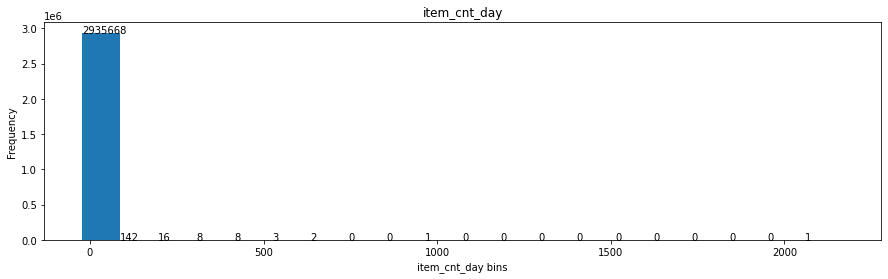



Time taken to run this procedure: 0.29 seconds


In [ ]:
instance.make_histogram(df, column_name, 20)

11. Frequency unique values of the column - item_cnt_day

In [ ]:
column_name = 'date_block_num'
instance.bin_num_range_selector(df, column_name)

Maximum: 33
Minimum: 0


Time taken to run this procedure: 0.01 seconds


In [ ]:
instance.bin_num_helper(0,34)

Bin size suggestions: [1, 2, 17]

Or any bin size from the range 1 to 20


Time taken to run this procedure: 0.0 seconds


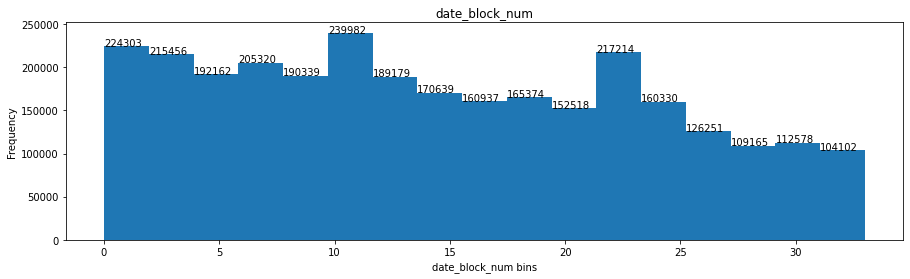



Time taken to run this procedure: 0.26 seconds


In [ ]:
instance.make_histogram(df, column_name, 17)

12 - Check for data quality in each value of each column - quantitative_columns

In [ ]:
quantitative_columns, quanlitative_columns = instance.get_column_lists(df)



Time taken to run this procedure: 0.03 seconds


In [ ]:
numeric_df = instance.convert_columns_string(df)



Time taken to run this procedure: 8.11 seconds


In [ ]:
column_list = numeric_df.columns

In [ ]:
column_list

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')

In [ ]:
instance.check_column_values(numeric_df, column_list)



Check if all characters in the string are whitespaces. True if space exists, else False.
Column name: date
[False]
Column name: date_block_num
[False]
Column name: shop_id
[False]
Column name: item_id
[False]
Column name: item_price
[False]
Column name: item_cnt_day
[False]


Check whether all characters are numeric. True if only numeric, else False.
Column name: date
[False]
Column name: date_block_num
[ True]
Column name: shop_id
[ True]
Column name: item_id
[ True]
Column name: item_price
[False]
Column name: item_cnt_day
[False]


Check whether all characters are only alphabetic. True if there are only alphabets, else False.
Column name: date
[False]
Column name: date_block_num
[False]
Column name: shop_id
[False]
Column name: item_id
[False]
Column name: item_price
[False]
Column name: item_cnt_day
[False]


Check whether all characters are only digits. True if there are only digits, else False.
Column name: date
[False]
Column name: date_block_num
[ True]
Column name: shop_id
[

13 - Check for data quality in each value of each column - quanlitative_columns

In [ ]:
instance.check_column_values(df, quanlitative_columns)



Check if all characters in the string are whitespaces. True if space exists, else False.
Column name: date
[False]


Check whether all characters are numeric. True if only numeric, else False.
Column name: date
[False]


Check whether all characters are only alphabetic. True if there are only alphabets, else False.
Column name: date
[False]


Check whether all characters are only digits. True if there are only digits, else False.
Column name: date
[False]


Check whether all characters are only decimal. True if there are only decimal, else False.
Column name: date
[False]


Check whether all characters are only lower. True if there are only lower case, else False.
Column name: date
[False]


Check whether all characters are only upper. True if there are only upper case, else False.
Column name: date
[False]


Check whether all characters are only upper. True if there are only upper case, else False.
Column name: date
[False]


Time taken to run this procedure: 4.98 seconds


14 - Get the descriptive statistics of the columns

In [ ]:
instance.numeric_details_list(df, quantitative_columns)

Number of numeric columns: 5
['date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day']


Column Name: date_block_num
count    2.935849e+06
mean     1.456991e+01
std      9.422988e+00
min      0.000000e+00
25%      7.000000e+00
50%      1.400000e+01
75%      2.300000e+01
max      3.300000e+01
Name: date_block_num, dtype: float64


median: 14.0
mode: 0    11
dtype: int64


Column Name: shop_id
count    2.935849e+06
mean     3.300173e+01
std      1.622697e+01
min      0.000000e+00
25%      2.200000e+01
50%      3.100000e+01
75%      4.700000e+01
max      5.900000e+01
Name: shop_id, dtype: float64


median: 31.0
mode: 0    31
dtype: int64


Column Name: item_id
count    2.935849e+06
mean     1.019723e+04
std      6.324297e+03
min      0.000000e+00
25%      4.476000e+03
50%      9.343000e+03
75%      1.568400e+04
max      2.216900e+04
Name: item_id, dtype: float64


median: 9343.0
mode: 0    20949
dtype: int64


Column Name: item_price
count    2.935849e+06
mean     8.908532e+0

In [ ]:
column_name = 'item_price'
instance.check_positive(df, column_name)

[ True False]


Time taken to run this procedure: 0.02 seconds


In [ ]:
series = df[column_name] < 0
instance.get_index_list(df, series)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [ ]:
df['item_price'].std()

1729.7996307129863

15 - Get outliers of item_price

In [ ]:
column_name = 'item_price'

In [ ]:
instance.print_outlier_values(df, column_name)

Higher outliers: 2124.0
Lower outliers: -876.0


Time taken to run this procedure: 0.07 seconds


In [ ]:
higher_df, lower_df = instance.get_outlier_dfs(df, column_name)



Time taken to run this procedure: 0.11 seconds


In [ ]:
higher_df

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
37,02.01.2013,0,25,2719,2699.0,1.0
38,12.01.2013,0,25,2719,2699.0,1.0
158,03.01.2013,0,25,2253,2199.0,1.0
159,18.01.2013,0,25,2253,2199.0,1.0
160,26.01.2013,0,25,2254,2199.0,1.0
...,...,...,...,...,...,...
2935782,30.10.2015,33,25,7134,3599.0,1.0
2935802,19.10.2015,33,25,7583,2150.0,1.0
2935804,29.10.2015,33,25,7610,2890.0,1.0
2935813,01.10.2015,33,25,7640,4040.0,1.0


In [ ]:
lower_df

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


### 2 - shops.csv

In [ ]:
df_shops = pd.read_csv('shops.csv')

In [ ]:
list1 = df_shops['shop_id'].unique()
list2 = df['shop_id'].unique()

In [ ]:
list_difference_1 = [item for item in list1 if item not in list2]


In [ ]:
len(list_difference_1)

0

In [ ]:
list_difference_2 = [item for item in list2 if item not in list1]


In [ ]:
len(list_difference_2)

0

### 3 - items.csv

In [ ]:
df_items = pd.read_csv('items.csv')

In [ ]:
list1 = df_items['item_id'].unique()
list2 = df['item_id'].unique()

In [ ]:
list_difference_1 = [item for item in list1 if item not in list2]



In [ ]:
len(list_difference_1)

363

In [ ]:
list_difference_2 = [item for item in list2 if item not in list1]



In [ ]:
len(list_difference_2)

0

## 3. Conlclusions

#### 1. Insights

1. sales_train
  1. All features, except date are quantitative
  2. There are no NaN values in this table, no duplicates and all column values are clean
  3. The number of items (99.994%) sold per day is mostly less than 142
  4. Most items sell more than 10K units overall. There is some sense of uniformity in the number of items being sold overall
  5. The sale in different shops is certainly not uniform. Some shops sell better than others (Shops with ids from 20 to 35 do very well. The shop_ids less than 20 does worse than shop_ids more than 35)
  6. Looking at the sales per date-block, we can see that the sales have decreased over the years from 2013 to 2015 with a couple of spikes in between. The year 2013 begins with 200K+ items sold and at the end of 2015 we see it almost halved with 100K+ items sold
  7. The price is of items is higly varied. The higher outliers are above 2124. 9% rows fall in this category. 




#### 2. Action Items

**Basic Cleaning**

1. Combine sales_train and item_categories with item_id


**df_sales_train**
1. Split the 'date' column to day, month, year, is weekday or not
2. Set ['item_price', 'item_cnt_day'] to two decimal places
3. There is a row where item_id = 0. Check if this is a valid item_id. If it is invalid, remove this row
4. There is a row with index 484683 where the price is negative


**df_shops**



**df_items**


**df_item_categories**



#### 3. Task

The final submission file contains an ID feature (the shop id) and the feature item_cnt_month, which is the total items sold in a month